In [1]:
import torch
from torch.utils.data import Dataset
import glob
import argparse
import os
import numpy as np
import pickle
from PIL import Image
from tqdm import tqdm


In [2]:
cd ..\..

E:\CVprojects\Butterflies


In [3]:
# !git clone https://github.com/orobix/Prototypical-Networks-for-Few-shot-Learning-PyTorch.git

In [4]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

In [5]:
cd src\Prototypical_Networks_for_Few_shot_Learning_PyTorch\src

E:\CVprojects\Butterflies\src\Prototypical_Networks_for_Few_shot_Learning_PyTorch\src


In [6]:
from prototypical_batch_sampler import PrototypicalBatchSampler
from prototypical_loss import prototypical_loss as loss_fn
from protonet import ProtoNet
from parser_util import get_parser

In [7]:
cd ..\..\..

E:\CVprojects\Butterflies


In [8]:
cd src

E:\CVprojects\Butterflies\src


In [9]:
from Butterfly200DataSet import Butterfly200DataSet

In [10]:
cd ..

E:\CVprojects\Butterflies


In [11]:
split_dict_name = "split_dict2.pkl"
split_dict_path = 'configs\\splits\\'+split_dict_name
split_dict_path

'configs\\splits\\split_dict2.pkl'

In [12]:
# %pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [13]:
def init_seed(opt):
    torch.cuda.cudnn_enabled = True
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)
def init_dataset(opt, mode):
    dataset = Butterfly200DataSet(split_dict_path,mode=mode)
    n_classes = len(np.unique(dataset.y))
    if n_classes < opt.classes_per_it_tr or n_classes < opt.classes_per_it_val:
        raise(Exception('There are not enough classes in the dataset in order ' +
                        'to satisfy the chosen classes_per_it. Decrease the ' +
                        'classes_per_it_{tr/val} option and try again.'))
    return dataset


def init_sampler(opt, labels, mode):
    if 'train' in mode:
        classes_per_it = opt.classes_per_it_tr
        num_samples = opt.num_support_tr + opt.num_query_tr
    else:
        classes_per_it = opt.classes_per_it_val
        num_samples = opt.num_support_val + opt.num_query_val

    return PrototypicalBatchSampler(labels=labels,
                                    classes_per_it=classes_per_it,
                                    num_samples=num_samples,
                                    iterations=opt.iterations)
def init_dataloader(opt, mode):
    dataset = init_dataset(opt, mode)
    sampler = init_sampler(opt, dataset.y, mode)
    dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)
    return dataloader
def init_protonet(opt):
    '''
    Initialize the ProtoNet
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    model = ProtoNet().to(device)
    return model
def init_optim(opt, model):
    '''
    Initialize optimizer
    '''
    return torch.optim.Adam(params=model.parameters(),
                            lr=opt.learning_rate)
def init_lr_scheduler(opt, optim):
    '''
    Initialize the learning rate scheduler
    '''
    return torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                           gamma=opt.lr_scheduler_gamma,
                                           step_size=opt.lr_scheduler_step)
def save_list_to_file(path, thelist):
    with open(path, 'w') as f:
        for item in thelist:
            f.write("%s\n" % item)

In [14]:
def train(opt, tr_dataloader, model, optim, lr_scheduler, val_dataloader=None):
    '''
    Train the model with the prototypical learning algorithm
    '''

    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'

    if val_dataloader is None:
        best_state = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    best_model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    last_model_path = os.path.join(opt.experiment_root, 'last_model.pth')

    for epoch in range(opt.epochs):
        print('=== Epoch: {} ==='.format(epoch))
        tr_iter = iter(tr_dataloader)
        model.train()
        
        for batch in tqdm(tr_iter):
            optim.zero_grad()
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
#             print(model_output.shape)
#             print(y)
#             print(opt.num_support_tr)
            loss, acc = loss_fn(model_output, target=y,
                                n_support=opt.num_support_tr)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
            train_acc.append(acc.item())
            torch.cuda.empty_cache()
        avg_loss = np.mean(train_loss[-opt.iterations:])
        avg_acc = np.mean(train_acc[-opt.iterations:])
        print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
        if val_dataloader is None:
            continue
        val_iter = iter(val_dataloader)
        model.eval()
        for batch in tqdm(val_iter):
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            loss, acc = loss_fn(model_output, target=y,
                                n_support=opt.num_support_val)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
            torch.cuda.empty_cache()
        avg_loss = np.mean(val_loss[-opt.iterations:])
        avg_acc = np.mean(val_acc[-opt.iterations:])
        postfix = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(
            best_acc)
        print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(
            avg_loss, avg_acc, postfix))
        if avg_acc >= best_acc:
            torch.save(model.state_dict(), best_model_path)
            best_acc = avg_acc
            best_state = model.state_dict()

    torch.save(model.state_dict(), last_model_path)

    for name in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
        save_list_to_file(os.path.join(opt.experiment_root,
                                       name + '.txt'), locals()[name])

    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc


def test(opt, test_dataloader, model):
    '''
    Test the model trained with the prototypical learning algorithm
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    avg_acc = list()
    for epoch in tqdm(range(opt.test_epochs)):
        test_iter = iter(test_dataloader)
        for batch in test_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            _, acc = loss_fn(model_output, target=y,
                             n_support=opt.num_support_val)
            avg_acc.append(acc.item())
    avg_acc = np.mean(avg_acc)
    print('Test Acc: {}'.format(avg_acc))

    return avg_acc


def eval(opt):
    '''
    Initialize everything and train
    '''
    options = get_parser().parse_args()

    if torch.cuda.is_available() and not options.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    init_seed(options)
    test_dataloader = init_dataset(options)[-1]
    model = init_protonet(options)
    model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    model.load_state_dict(torch.load(model_path))

    test(opt=options,
         test_dataloader=test_dataloader,
         model=model)




In [15]:
d = {
    'experiment_root':'base_exp',
     'epochs':20,
     'test_epochs':10,
    'iterations':200,
     'cuda':True,
     'classes_per_it_tr':5,
    'lr_scheduler_step':20,
    'num_query_tr':1,
    'num_support_tr':2,
    'num_query_val':1,
     'num_support_val':1,
    'learning_rate':0.001,
#      'check_point_path':'base_exp/best_after_blur_t48_val50.pth'
     }
options = get_parser().parse_args('')

for key, value in d.items():
        setattr(options, key, value)

In [16]:
options.num_query_tr

1

In [17]:
options.num_support_tr

2

In [18]:
torch.cuda.empty_cache()

In [19]:
split_dict_path

'configs\\splits\\split_dict2.pkl'

In [20]:
'''
Initialize everything and train
'''
# options = get_parser().parse_args()
if not os.path.exists(options.experiment_root):
    os.makedirs(options.experiment_root)

if torch.cuda.is_available() and not options.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

init_seed(options)

tr_dataloader = init_dataloader(options, 'train')
val_dataloader = init_dataloader(options, 'val')
# test_dataloader = init_dataloader(options, 'test')



100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 167.34it/s]


In [21]:
model = init_protonet(options)
if 'check_point_path' in options:
    model.load_state_dict(torch.load(options.check_point_path))



In [22]:
model

ProtoNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), st

In [23]:
optim = init_optim(options, model)
lr_scheduler = init_lr_scheduler(options, optim)

- about 10 epochs with 40 classes training: 5 query - 5 support, val: query 4 - sup 3
- about 5 epochs with same as above but 10 classes (no significant change)

best: 52 train - 56 val
- increase the number of the maximum number of samples per class from 50 to 200 

best: 48 train - 67 val (with dropout on the -2 and -3 layers)

-Using clusters

best 34 train 72 val

- current exp:
92 epoch:42 val- 19 train (20 class - 20 iterations- 1,2 query - 2 sup)

200 epoch: 56 val - 38 train (20 class - 20 iterations - 1,2,3 query - 2,3 sup)
10 epochs: 55.8 val - 29 train (60 class - 100 iterations - ...)

In [24]:
res = train(opt=options,
            tr_dataloader=tr_dataloader,
            val_dataloader=val_dataloader,
            model=model,
            optim=optim,
            lr_scheduler=lr_scheduler)
best_state, best_acc, train_loss, train_acc, val_loss, val_acc = res

=== Epoch: 0 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.15it/s]


Avg Train Loss: 259.05154153466225, Avg Train Acc: 0.48300001144409177


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.44it/s]


Avg Val Loss: 201.98702821850776, Avg Val Acc: 0.4290000100433826 (Best)
=== Epoch: 1 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.04it/s]


Avg Train Loss: 53.381200267310376, Avg Train Acc: 0.5180000128597021


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.78it/s]


Avg Val Loss: 80.51106334090233, Avg Val Acc: 0.4180000098794699 (Best: 0.4290000100433826)
=== Epoch: 2 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.02it/s]


Avg Train Loss: 23.12147779941267, Avg Train Acc: 0.5570000130683184


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.44it/s]


Avg Val Loss: 66.76724508101121, Avg Val Acc: 0.40300000973045824 (Best: 0.4290000100433826)
=== Epoch: 3 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.83it/s]


Avg Train Loss: 12.66984880868181, Avg Train Acc: 0.6140000129491091


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.51it/s]


Avg Val Loss: 37.4572147154808, Avg Val Acc: 0.43200001031160357 (Best)
=== Epoch: 4 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.59it/s]


Avg Train Loss: 5.9164940638342385, Avg Train Acc: 0.6790000131726265


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.81it/s]


Avg Val Loss: 23.008449227754028, Avg Val Acc: 0.4050000090152025 (Best: 0.43200001031160357)
=== Epoch: 5 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.94it/s]


Avg Train Loss: 3.7965285045501376, Avg Train Acc: 0.6880000142008066


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.73it/s]


Avg Val Loss: 22.31521014392376, Avg Val Acc: 0.4390000107884407 (Best)
=== Epoch: 6 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.85it/s]


Avg Train Loss: 2.80886023317876, Avg Train Acc: 0.6990000127255916


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.07it/s]


Avg Val Loss: 11.371268465816975, Avg Val Acc: 0.4000000092387199 (Best: 0.4390000107884407)
=== Epoch: 7 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.61it/s]


Avg Train Loss: 1.3261039684870624, Avg Train Acc: 0.7640000107139349


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.59it/s]


Avg Val Loss: 9.763569560870529, Avg Val Acc: 0.3920000093430281 (Best: 0.4390000107884407)
=== Epoch: 8 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:44<00:00,  4.46it/s]


Avg Train Loss: 1.0884871353671224, Avg Train Acc: 0.7580000122636557


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.94it/s]


Avg Val Loss: 9.168794903308154, Avg Val Acc: 0.40500000983476636 (Best: 0.4390000107884407)
=== Epoch: 9 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:44<00:00,  4.48it/s]


Avg Train Loss: 0.8130880113984312, Avg Train Acc: 0.7970000100135803


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.70it/s]


Avg Val Loss: 7.425144909098744, Avg Val Acc: 0.42300001077353955 (Best: 0.4390000107884407)
=== Epoch: 10 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.28it/s]


Avg Train Loss: 0.6642206756609812, Avg Train Acc: 0.7950000103563071


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.54it/s]


Avg Val Loss: 6.498958454728126, Avg Val Acc: 0.4020000094175339 (Best: 0.4390000107884407)
=== Epoch: 11 ===


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.51it/s]


Avg Train Loss: 0.6453331116284243, Avg Train Acc: 0.7860000109672547


 60%|████████████████████████████████████████████████                                | 120/200 [00:23<00:15,  5.18it/s]


KeyboardInterrupt: 

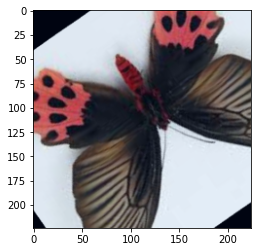

In [51]:
import matplotlib.pyplot as plt
sample = next(iter(tr_dataloader))[0][1].detach().cpu().numpy()
sample = sample-np.min(sample)
sample = sample*1/np.max(sample)
sample = np.swapaxes(sample, 0, 2)
sample = np.swapaxes(sample, 0, 1)
plt.imshow(sample)

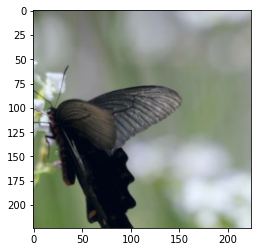

In [52]:
sample = next(iter(val_dataloader))[0][1].detach().cpu().numpy()
sample = sample-np.min(sample)
sample = sample*1/np.max(sample)

sample = np.swapaxes(sample, 0, 2)
sample = np.swapaxes(sample, 0, 1)
plt.imshow(sample)

In [28]:
sample.shape

(224, 224, 3)

In [25]:
last_model_path = os.path.join(options.experiment_root,'last_model.pth')
torch.save(model.state_dict(),last_model_path )

In [ ]:
model.load_state_dict(torch.load('base_exp/best_model.pth'))

In [65]:
test_dataloader = init_dataloader(options, 'test')




100%|██████████| 2378/2378 [07:35<00:00,  5.22it/s]


Testing with last model..
Test Acc: 0.458500000834465


0.458500000834465

In [68]:
print('Testing with last model..')
test(opt=options,
      test_dataloader=test_dataloader,
      model=model)

Testing with last model..
Test Acc: 0.44860000163316727


0.44860000163316727

In [ ]:
model.load_state_dict(best_state)
print('Testing with best model..')
test(opt=options,
      test_dataloader=test_dataloader,
      model=model)